In [497]:
#%matplotlib notebook
import numpy as np
from scipy.signal import decimate
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.interpolate import interp1d
from scipy.signal import resample

In [582]:
# working version detection

class AutoTune():
    
    def __init__(self, wav):
        
        
        assert len(wav) > 8*220
        
        # original audio
        self.wav = np.array(wav)
        
        # 1/8 decimation
        self.down_wav = decimate(self.wav, q=8)
        print(self.down_wav.shape)
        # declare tables
        self.Ei_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.Hi_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.subTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.truTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.real_freq = np.zeros(len(self.wav), dtype=float)
        
        self.idxTable = []
        
        # first value of e table
        for L in range(2,111):
            self.Ei_Table[220,L] = sum(np.square(self.down_wav[221-2*L:221]))
            self.Hi_Table[220,L] = sum(np.multiply(self.down_wav[221-2*L:221-L], self.down_wav[221-L:221]))

        # loop to initialize tables
        for i in range(221, len(self.down_wav)):
            indx = []
            
            for L in range(2,111):
                self.Ei_Table[i, L] = self.Ei_Table[i-1, L] + self.down_wav[i]**2 - self.down_wav[i-2*L]**2
                self.Hi_Table[i, L] = self.Hi_Table[i-1, L] + self.down_wav[i]*self.down_wav[i-L] - self.down_wav[i-L]*self.down_wav[i-2*L]
                self.subTable[i, L] = self.Ei_Table[i, L] - 2*self.Hi_Table[i, L]
                
                # set sensitivity, lower is more selective
                sensitivity = 0.01
                #self.truTable[i, L] = self.subTable[i, L]<0.03*A.Ei_Table[i, L]
                if self.subTable[i, L] < sensitivity*self.Ei_Table[i, L] and L > 10 and L < 70:
                    value, freq = self.get_real_freq(i, L)
                    self.real_freq[i*8:(i+1)*8] = freq
                    if not i % 1000:
                        print('i:',i,'bigL:',8*L,'freq:',freq)
                    break
                    
                if L == 110:
                    self.real_freq[i*8:(i+1)*8] = self.real_freq[i*8-1]
                    
            
            # append successes to index list
            #self.idxTable.append(indx)
            
            
           
    def get_real_freq(self, down_indx, down_f_est):

        
        # convert to real signal indecies
        real_indx = 8*down_indx
        real_f_est = 8*down_f_est

        # create Ls index to calculate E and H for
        real_line = np.linspace(real_f_est-9,real_f_est+9,19, dtype=int)
        real_mins = np.zeros(len(real_line), dtype=float)

        for L in real_line:
            a = np.array(self.wav[real_indx-2*L+1:real_indx-L+1], dtype=np.float64)
            b = np.array(self.wav[real_indx-L+1:real_indx+1], dtype=np.float64)
            #print('E: ', self.wav[real_indx-2*L+1:real_indx+1])
            #print('H: ',self.wav[real_indx-2*L+1:real_indx-L+1],self.wav[real_indx-L+1:real_indx+1] )
            E = np.sum(np.square(a)) + np.sum(np.square(b))
            H = sum(a*b)
            
            val = (E-2*H)/E
            real_mins[L-real_line[0]] = val
        
        interpolation_line = np.linspace(real_line[0],real_line[-1],100, endpoint=True)
        int_obj = interp1d(real_line, real_mins, kind='cubic')
        interpolated = int_obj(interpolation_line)
        final_lag = interpolation_line[np.argmin(interpolated)]
        value = np.min(interpolated)

        return(value, (1/(final_lag/44100)))

    def build_output(self):
        self.output = np.zeros_like(self.wav)
        desired = np.flip(np.linspace(75,300,len(self.output),endpoint=True))
        i_pnt = 21000
        o_pnt = 21000
        
        while i_pnt < (len(desired)-500) and o_pnt < (len(desired)-500):
            
            cur_freq = self.real_freq[i_pnt]
            des_freq = desired[o_pnt]
            i_sz = np.rint(cur_freq/44100, dtype=np.int64)
            o_sz = np.rint(i_sz*(cur_freq/des_freq), dtype=np.int64)
            
            out_slice = resample(self.wav[i_pnt:i_pnt+i_sz+1], o_sz)
            self.output[o_pnt:o_pnt+o_sz+1] = out_slice
            
            i_pnt += i_sz+1
            o_pnt += o_sz+1
            
            if abs(i_pnt - o_pnt) > o_sz:
                if i_pnt < o_pnt:
                    o_pnt -= o_sz+1
                if i_pnt > o_pnt:
                    self.output[o_pnt:o_pnt+o_sz+1] = out_slice
                    o_pnt += o_sz+1
        
        

In [501]:
A.real_freq[21000]

98.01980198019803

In [595]:
# synthetic
freq = 250
data = np.sin(np.arange(50000,dtype=float)*2*freq*np.pi/(44100.0))

fs, data = wavfile.read('sweep.wav')
data=data[:,0]
#data=data[100000:200000]
#print(data[:50])
data.shape

(516032,)

In [596]:
A = AutoTune(data)
A.subTable.shape

(64504,)
i: 3000 bigL: 480 freq: 92.45283018867924
i: 5000 bigL: 424 freq: 105.34201954397395
i: 6000 bigL: 400 freq: 110.27506251420776
i: 8000 bigL: 408 freq: 110.52631578947368
i: 9000 bigL: 360 freq: 122.03773584905659
i: 11000 bigL: 456 freq: 98.65771812080537
i: 12000 bigL: 448 freq: 100.45558086560365
i: 13000 bigL: 376 freq: 120.1634877384196
i: 14000 bigL: 336 freq: 133.4525447042641
i: 15000 bigL: 328 freq: 134.5631067961165
i: 16000 bigL: 320 freq: 138.0871050384287
i: 17000 bigL: 312 freq: 141.55237817332943
i: 18000 bigL: 312 freq: 143.9038860872145
i: 19000 bigL: 328 freq: 138.24451410658307
i: 20000 bigL: 352 freq: 122.1606648199446
i: 21000 bigL: 296 freq: 151.83098591549296
i: 22000 bigL: 288 freq: 154.73684210526318
i: 23000 bigL: 280 freq: 157.7560975609756
i: 24000 bigL: 344 freq: 127.82608695652172
i: 25000 bigL: 264 freq: 167.33356329768884
i: 26000 bigL: 272 freq: 164.71986417657044
i: 27000 bigL: 272 freq: 166.07326258130774
i: 28000 bigL: 304 freq: 140.89456869

(64504, 111)

127442


516032

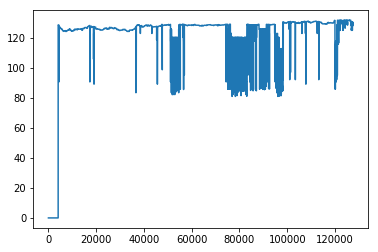

In [576]:
plt.plot(A.real_freq)
print(len(A.real_freq))
64504*8

In [597]:
def build_output(self):
    output = np.zeros_like(self.wav)
    #desired = (np.linspace(75,500,len(output),endpoint=True))
    desired = np.ones_like(self.wav)*150
    i_pnt = 21000
    o_pnt = 21000

    while i_pnt < (len(desired)-500) and o_pnt < (len(desired)-500):
        
        cur_freq = self.real_freq[i_pnt]
        des_freq = desired[o_pnt]
        
        if cur_freq < 70:
            output[o_pnt:o_pnt+100+1] = self.wav[i_pnt:i_pnt+100+1]
            i_pnt += 100+1
            o_pnt += 100+1
        
        i_sz = int(np.rint(44100/cur_freq))
        o_sz = int(np.rint(i_sz*(cur_freq/des_freq)))
        
        #print(i_sz*cur_freq/des_freq)
        #print(o_sz)
        
        out_slice = resample(self.wav[i_pnt:i_pnt+i_sz+1], o_sz)
        #print(len(out_slice))
        output[o_pnt:o_pnt+o_sz] = out_slice

        i_pnt += int(i_sz)
        o_pnt += int(o_sz)

        if abs(i_pnt - o_pnt) > o_sz:
            if i_pnt < o_pnt:
                o_pnt -= o_sz
            if i_pnt > o_pnt:
                output[o_pnt:o_pnt+o_sz] = out_slice
                o_pnt += o_sz

    return output

In [598]:
ot = build_output(A)
#sd.play(A.output, 44100)

In [610]:
sd.play(ot,44100)

In [606]:
sd.play(A.wav)

In [447]:
# indx of dwnsmpld to freq
dsf = (44100/8) #samp/sec
indx = 55 # samps
freq = 1/(indx/dsf)
freq

100.22727272727273

In [446]:
# indx of dwnsmpld to freq
dsf = (44100) #samp/sec
indx = (70)*8 # samps
freq = 1/(indx/dsf)
freq

78.75